# Cohort Analyses

## References

|Link|Notes|
|---|---|
|https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html|Basic spread models|
|https://www.insidermonkey.com/blog/donald-trump-has-3-3-percent-chance-of-dying-from-coronavirus-817781/|Basic risk mdoel|

## Imports and Setup

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from ipypb import track
import datetime as dt

## Data

Data Sources (keep it simple and focus on building the models)
- https://covidtracking.com/api/
- New York Times

In [2]:
nytCountyData = "C:\\Users\\garfink2\\Documents\\data\\covid\\covid-19-data\\us-counties.csv"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"
shp_USStates = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_state\\tl_2017_us_state.shp"

In [3]:
df_nytCountyData = pd.read_csv(nytCountyData)
gdf_USCounties = gpd.read_file(shp_USCounties)
gdf_USStates = gpd.read_file(shp_USStates)

In [27]:
df_nytCountyData = df_nytCountyData.dropna(subset=["fips"])

In [28]:
df_nytCountyData["fips"] = df_nytCountyData["fips"].astype("int")

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_nytCountyData.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [30]:
gdf_USCounties["GEOID"] = gdf_USCounties["GEOID"].astype("int")

In [33]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry"]]

In [34]:
gdf_USCounties.head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry
0,31,039,31039,Cuming,Cuming County,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,53069,Wahkiakum,Wahkiakum County,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,35011,De Baca,De Baca County,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,31109,Lancaster,Lancaster County,"POLYGON ((-96.91060 40.95841, -96.91060 40.958..."
4,31,129,31129,Nuckolls,Nuckolls County,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


In [38]:
gdf_countyTimeSeries = gpd.GeoDataFrame(pd.merge(left=df_nytCountyData,right=gdf_USCounties,left_on="fips",right_on="GEOID"))

In [40]:
gdf_countyTimeSeries['date'] = pd.to_datetime(gdf_countyTimeSeries['date'], errors='coerce')

In [41]:
gdf_countyTimeSeries.head()

,date,county,state,fips,cases,deaths,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry
0,2020-01-21,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0..."
1,2020-01-22,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0..."
2,2020-01-23,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0..."
3,2020-01-24,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0..."
4,2020-01-25,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0..."


In [59]:
def filterByDate(gdf,dateColumn="date",month=3,day=27,year=2020,operator="="):
    filterDate = dt.datetime(month=month,day=day,year=year)
    if operator == "=":
        gdf = gdf[gdf[dateColumn] == filterDate]
    elif operator == "<":
        gdf = gdf[gdf[dateColumn] < filterDate]
    elif operator == "<=":
            gdf = gdf[gdf[dateColumn] <= filterDate]
    elif operator == ">":
            gdf = gdf[gdf[dateColumn] > filterDate]
    elif operator == ">=":
            gdf = gdf[gdf[dateColumn] >= filterDate]
    else:
        raise(Exception("error, operator not recognized"))
    return gdf

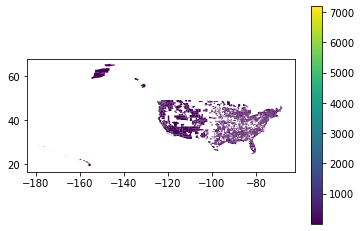

In [60]:
filterByDate(gdf_countyTimeSeries).plot("cases",legend="True")

## Assumptions

In [ ]:
rate_fatality = 0.8/100 # https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html
days_to_onset = 5
days_to_hospitalization = 10
days_to_outcome = 24

## Analyses

Estimating cohort risk

- Assume $P_{{infection}}$ is homogenous and homogenous both spatially and across population subsets
- Specify assumed rates for $P_{{{{hospitalization}}_{{age}}}}$ and $P_{{{{death}}_{{age}}}}$
- Specify assumed rates for $P_{{{{absence}}_{{non-illness}}}}$